<a href="https://colab.research.google.com/github/Rohit-Saswadkar/Font-Text-classification-project-using-CNN/blob/main/1%5D_Model_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Font Recognition Model Architecture using CNN

##**Advancements**

1. Added padding to the images and maintained aspect ratio
2. Applied Gaussin blur to reduce noise and add smoother boundaries
3. Data Augmentation techniques
4. Improved Model Architecture
5. Early stoppin while training

**This techniques are explained at each implementation stage.**

by Rohit Saswadkar
* Email - rohit.saswadkar1@gmail.com
* Linkedin - linkedin.com/in/rohit-saswadkar-595453237
* Project Link - https://github.com/Rohit-Saswadkar/Font-Text-classification-project-using-CNN/tree/main\
* Dataset download link - https://www.kaggle.com/datasets/muhammadardiputra/font-recognition-data/download?datasetVersionNumber=1
* Dataset website - https://www.kaggle.com/datasets/muhammadardiputra/font-recognition-data

Install required libraries
1] tensorflow to create a model
2] open cv for image processing

In [1]:
!pip install tensorflow
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1] Import required libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [4]:
image_width = 128
image_height = 32

**2] Download the dataset from the provided link and paste the file path below to begin the training process.**
* There are 2 Datasets 1] Font dataset large and 2] Font dataset large color.
* I trained on Font dataset large (gray scale) to reduce computation load on system. Load that "Font dataset large" datasets in the path

In [5]:
# Load the font dataset
path = r"/content/drive/MyDrive/Data Science Advanced Projects/1 Data Science Advanced/Deep learning/Font recognition assessment/New Data/New Start"

##**Data Ingestion**

3] This function loads font images and their corresponding labels from the specified directory. It get input as dictionary , extracts the images and its corresponding labels and stores this into images and labels lists.

* I used cv2 to convert the color images to grayscale as we have to only text classification ( also it reduce the computationl load on the laptop). we can also train the model using color data as we have to only remove the line number 1] as shown in below


**Improvements:**
* Added Gaussian blur which will reduce the noise in the image and smoothens the boundaries which make the model robust and genralize well on unseen data

*  Converted all image in the size of 32 x 128 while maintaining Aspect ratio as the images in our dataset arent of uniform size so I mainrtained their aspect ration and resized to 32x 128 which will balance the short and long words of the dataset.

* For this I use open cv to add padding and added 255 in those padded pixel as it will introduce white background to all images

In [6]:
def load_data(data_directory, target_height=32, target_width=128, apply_gaussian_blur=True):
    images = []
    labels = []
    font_names = os.listdir(data_directory)
    for font_name in font_names:
        font_dir = os.path.join(data_directory, font_name)
        for image_name in os.listdir(font_dir):
            image_path = os.path.join(font_dir, image_name)
            image = cv2.imread(image_path)

            # Apply Gaussian blur if specified
            if apply_gaussian_blur:
                image = cv2.GaussianBlur(image, (5, 5), 0)  # -------------------Applied gaussian blur which will reduce the noise and improve generalization

            # Convert to grayscale if input is any color image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # ------------------ 1] Conerted all images to grayscale as our images has 3 channels

            # Resize image while preserving aspect ratio
            h, w = image.shape
            aspect_ratio = w / h
            if aspect_ratio < (target_width / target_height):
                new_width = int(target_height * aspect_ratio)
                resized_image = cv2.resize(image, (new_width, target_height))
                pad_left = (target_width - new_width) // 2
                pad_right = target_width - new_width - pad_left
                resized_image = cv2.copyMakeBorder(resized_image, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value= 255)
            else:
                new_height = int(target_width / aspect_ratio)
                resized_image = cv2.resize(image, (target_width, new_height))
                pad_top = (target_height - new_height) // 2
                pad_bottom = target_height - new_height - pad_top
                resized_image = cv2.copyMakeBorder(resized_image, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value= 255)

            images.append(resized_image)
            labels.append(font_name)
    return np.array(images), np.array(labels)

In [7]:
data_directory = path
images, labels = load_data(data_directory)

In [8]:
print('\nDataset shape:', images.shape)

print('Labels of the dataset:',set(labels))


Dataset shape: (11952, 32, 128)
Labels of the dataset: {'Verdana', 'Times New Roman', 'Calibry', 'Georgia', 'Arial', 'Century'}


**4] Applied one hot encoding on the labels as we have multiple classes**

In [9]:
# Convert labels to one-hot encoding
label_to_index = {label: i for i, label in enumerate(np.unique(labels))}
index_to_label = {i: label for label, i in label_to_index.items()}
labels_encoded = np.array([label_to_index[label] for label in labels])
labels_one_hot = tf.keras.utils.to_categorical(labels_encoded)

**5] This code snippet splits the dataset into training, validation, and test sets using the train_test_split function.**

In [10]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42, stratify=labels_one_hot)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

**6] This code preprocesses the data by normalizing pixel values and reshaping the input data to match the CNN input shape.**

* Each value in matrix of an image represents the color range from 0 to 255 so
 I Normalized the values of each image by dividing by 255 to convert them in the range of 0 to 1.

In [11]:
# preprocess the data (normalize pixel values)
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# reshape data to match the input shape of the CNN
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

##**Data Augmentation:**

* It rotates the image by -15 to 15 degree
* Also does width shift and heigt shifts by 10%
* Shearing adds some tiltness to each image by +- 10%
* It zooms the image by 20 % and Zoomout by 20%
* After all transformations the newly created pixels are filled by nearest pixels

In [12]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.8, 1.2],
    fill_mode='nearest'
)

* The Geneartor genrates the augmented images as well as normal images on the fly ith batch size of 32 images to the model

In [26]:
# Create data generators for training and validation
train_data_generator = datagen.flow(X_train, y_train, batch_size=32)
val_data_generator = datagen.flow(X_val, y_val, batch_size=32)

##**Model architecture**

* 1] in this I created 32 filters as of size 3 * 3 and slides along the image to extract meaninful features.

* 2] I used max pooling to extract the most valuable features by size of 2 * 2 to minimize computation and reduce overfitting.

*  I used relu as activation function in hidden layer to introduce non linearity in the model which returns values if its positive else returns 0 if the vlues is negative.

* 3] Used Flatten layer as it flattens the input matrix into 1d array

* 4] I Created dense layers of 64 neurons to reduce computational power as I trained this model in my laptop and also it reduces overfitting.

* 5] I used softmax in output layer as its mostly used for classification tasks. it converts raw inputs to the probabilities of the classes.


**Advancements in architecture-**
* 1]  Added the zero padding in each convolutional layer in all Convolutional layers.
* 2] Added kernel initializer Xavier initializer using "glorot uniform"
* 3] Added Batch normalization which will normalize the output of the cnn layers effects faster generalization of the model.
* 2] Added 50% dropout neuron layer after each hidden layer.
* 3] Added Extra hidden layer of 64 neurons.

In [34]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(image_height, image_width , 1), kernel_initializer='glorot_uniform'),
    layers.BatchNormalization(),  # Batch normalization added here
    layers.LeakyReLU(alpha=0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_uniform'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_uniform'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.3),
    layers.Flatten(),
    layers.Dense(64, kernel_initializer='glorot_uniform'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(0.5),
    layers.Dense(64, kernel_initializer='glorot_uniform'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

**7] This code snippet compiles the CNN model with the specified optimizer, loss function, and metrics.**

* Used adam as learning to adjust the weights during each epochs as its robust to sparse or noisy gradients.

* I used categorical crossentropy as i applied one hot encoding on labels else we have to use sparse categoruical cross entropy.

* Used Accuracy as performance monitoring metrics during training as our classification task.

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**8] Early stopping**
* It stops the training when the change in loss is almost stoppd.
* It waits for change in validation loss upto 3 epochs.
* Finally it restores best performing weights on the validation set.

In [27]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

**9] This code snippet trains the CNN model on the training data and validates it on the validation data.**

* I applied 10 epochs to reduce computational load. (It took 2 hours to train the model on entire 153600 images).
* steps per epochs enssures that the all images of the train dataset should be trained even if they arent complitely divisible by 32

In [28]:
history = model.fit(train_data_generator,
          steps_per_epoch=len(X_train) // 32,
          epochs=10,  #---------------------------------- increase the number of epochs to allow for early stopping
          validation_data=val_data_generator,
          validation_steps=len(X_val) // 32,
          callbacks=[early_stopping])

Epoch 1/10
239/239 [==============================] - 97s 408ms/step - loss: 0.6800 - accuracy: 0.7062 - val_loss: 2.1387 - val_accuracy: 0.4825
Epoch 2/10
239/239 [==============================] - 97s 406ms/step - loss: 0.6609 - accuracy: 0.7178 - val_loss: 10.6830 - val_accuracy: 0.2357
Epoch 3/10
239/239 [==============================] - 104s 435ms/step - loss: 0.6357 - accuracy: 0.7287 - val_loss: 3.5712 - val_accuracy: 0.3496
Epoch 4/10
239/239 [==============================] - 97s 406ms/step - loss: 0.6059 - accuracy: 0.7467 - val_loss: 5.0221 - val_accuracy: 0.2934


In [23]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,  # -------------------------------------------increase the number of epochs to allow for early stopping
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
239/239 [==============================] - 95s 396ms/step - loss: 1.4788 - accuracy: 0.3415 - val_loss: 6.3887 - val_accuracy: 0.1647
Epoch 2/10
239/239 [==============================] - 96s 403ms/step - loss: 1.2634 - accuracy: 0.4176 - val_loss: 6.6498 - val_accuracy: 0.2161
Epoch 3/10
239/239 [==============================] - 110s 460ms/step - loss: 1.0752 - accuracy: 0.5073 - val_loss: 5.6056 - val_accuracy: 0.2765
Epoch 4/10
239/239 [==============================] - 95s 397ms/step - loss: 0.9947 - accuracy: 0.5497 - val_loss: 1.6330 - val_accuracy: 0.4868
Epoch 5/10
239/239 [==============================] - 96s 400ms/step - loss: 0.8941 - accuracy: 0.6003 - val_loss: 8.7192 - val_accuracy: 0.1896
Epoch 6/10
239/239 [==============================] - 94s 392ms/step - loss: 0.8508 - accuracy: 0.6249 - val_loss: 1.2692 - val_accuracy: 0.5397
Epoch 7/10
239/239 [==============================] - 93s 391ms/step - loss: 0.8030 - accuracy: 0.6532 - val_loss: 3.2804 - val_a

The model's accuracy on the training data is increasing, indicating successful learning. However, fluctuations in validation accuracy suggest the model might be overfitting to the training data. This could be due to a high learning rate causing the model to skip the global minimum during loss minimization.

##**Evaluation**

In [18]:
# Evaluates the model on test data and gets accuracvy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

75/75 [==============================] - 7s 99ms/step - loss: 4.4989 - accuracy: 0.1665
Test loss: 4.4989, Test accuracy: 0.1665


In [24]:
# Evaluates the model on validation data and gets accuracvy
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

60/60 [==============================] - 4s 70ms/step - loss: 0.5985 - accuracy: 0.7355
Validation Accuracy: 0.7354940176010132


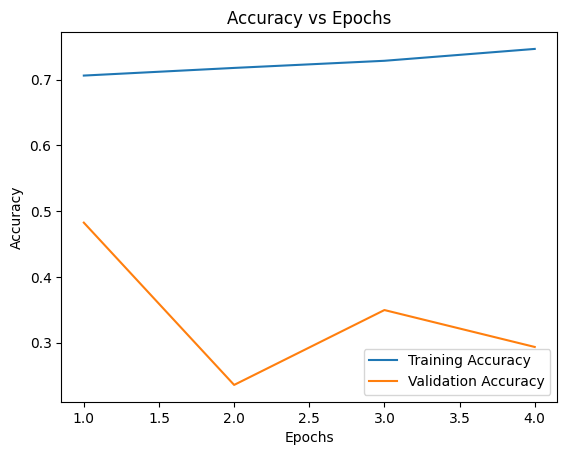

In [29]:
# Accessing accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plotting accuracy vs epochs
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

75/75 [==============================] - 12s 153ms/step


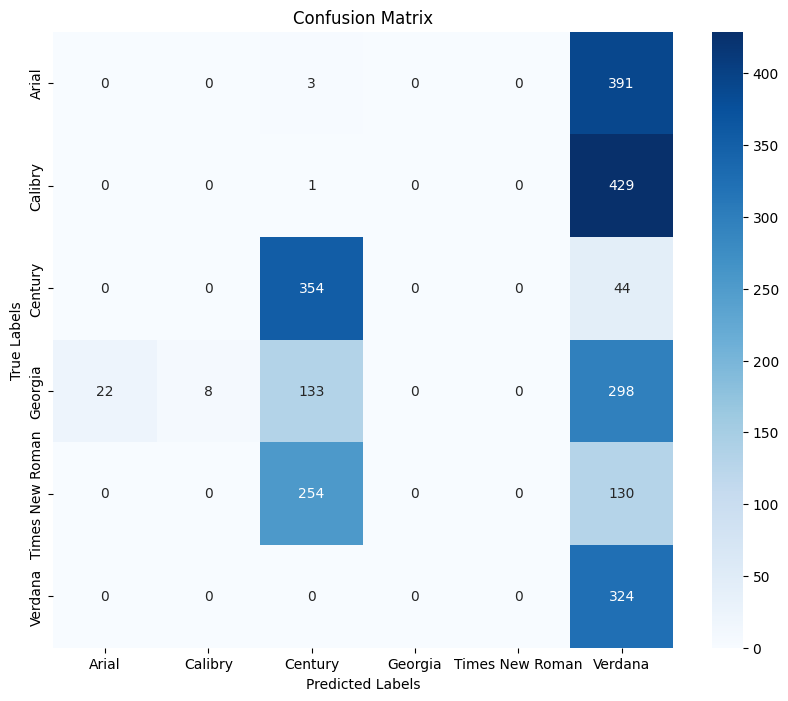

In [33]:
#  Visualize confusion matrix
predictions = model.predict(X_test)


predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**9] Save the model at specified path**

In [22]:
# Path eto save the model
path2 = r"/content/drive/MyDrive/Data Science Advanced Projects/1 Data Science Advanced/Deep learning/Font recognition assessment/New Data"

model.save(path + 'font_recognition_model_large_model_3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##**Conclusion -**

**Challenges -**

1. Model performance on train data is improving while on validation data its flactuating means model struggles to perform on unseen data and its underlying the overfitting problem.

2. Model loss changing slowly could be due to vanishing gradients or the learning rate is too small.

3. This could stem from factors such as model complexity or a learning rate that is too high, causing the model to skip the global minima and struggle with convergence.

**Solutoins -**
1. Hyperaparmeter tuning with activation functions, batch size,dropout nerons can lead to a better generalised model.

2. Regularization techniques such L@ regularization also can helpful.

3. Hyperparameter tuning with optimization techniques such as adam, stochastic gradient decent, NaG, RMS prop can also increase the performance.

4. Reducing model complexity by increasing dropout neurons, less hidden layers